# **Import Library**

In [ ]:
# library untuk menangani data
import zipfile
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Cek versi library
print("TensorFlow:", tf.__version__)

TensorFlow: 2.17.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [ ]:
# Path ke file zip di Google Drive
zip_path = '/content/drive/MyDrive/learning-agency-lab-automated-essay-scoring-2.zip'
extract_path = '/content/dataset'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memastikan bahwa file telah diekstrak
extracted_files = os.listdir(extract_path)
print("Files in extracted folder:", extracted_files)

# Cek apakah file yang dibutuhkan ada sebelum memuatnya
train_file = os.path.join(extract_path, 'train.csv')
test_file = os.path.join(extract_path, 'test.csv')
sample_submission_file = os.path.join(extract_path, 'sample_submission.csv')

if all(os.path.exists(file) for file in [train_file, test_file, sample_submission_file]):
    # Membaca dataset yang diekstraksi
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    sample_submission = pd.read_csv(sample_submission_file)


Files in extracted folder: ['test.csv', 'sample_submission.csv', 'train.csv']


# **Exploratory Data Analysis**

## Informasi Dataset

{test/train}.csv
* essay_id: Pengenal unik untuk setiap esai.
* full_text: Teks esai.
* score: Skor esai dengan rentang 1-6.

sample_submission.csv : Sampel valid yang dimasukkan untuk prediksi.  

In [ ]:
print('train data shape:', train.shape )
train.head()

train data shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
train.isnull().sum()

,0
essay_id,0
full_text,0
score,0


In [ ]:
print('test data shape:', test.shape )
test.head()

test data shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
test.isnull().sum()

,0
essay_id,0
full_text,0


In [ ]:
sample_submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


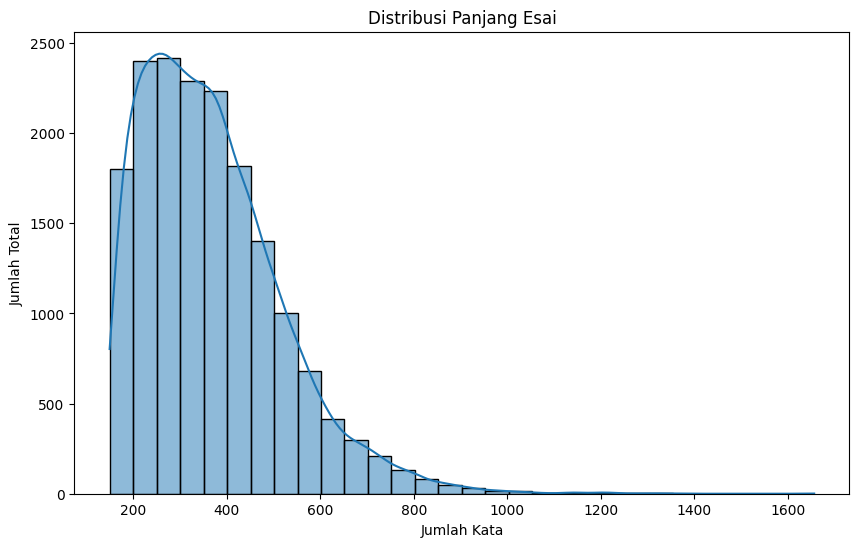

In [ ]:
# Menghitung panjang esai berdasarkan jumlah kata yang dipisahkan oleh spasi dalam setiap teks.
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True)
plt.title('Distribusi Panjang Esai')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Total')
plt.show()

In [ ]:
# Hitung jumlah kata pada setiap esai
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))

print(f"Minimum Panjang Esai: {essay_lengths.min()} kata")
print(f"Maximum Panjang Esai: {essay_lengths.max()} kata")
print(f"Rata-rata Panjang Esai: {essay_lengths.mean():.2f} kata")
print(f"Median Panjang Esai: {essay_lengths.median()} kata")
print(f"25th Persentil: {essay_lengths.quantile(0.25)} kata")
print(f"50th Persentil (Median): {essay_lengths.quantile(0.50)} kata")
print(f"75th Persentil: {essay_lengths.quantile(0.75)} kata")

Minimum Panjang Esai: 150 kata
Maximum Panjang Esai: 1656 kata
Rata-rata Panjang Esai: 368.35 kata
Median Panjang Esai: 345.0 kata
25th Persentil: 253.0 kata
50th Persentil (Median): 345.0 kata
75th Persentil: 452.0 kata


<ipython-input-13-17e5cb8ffaec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=train, palette='viridis')


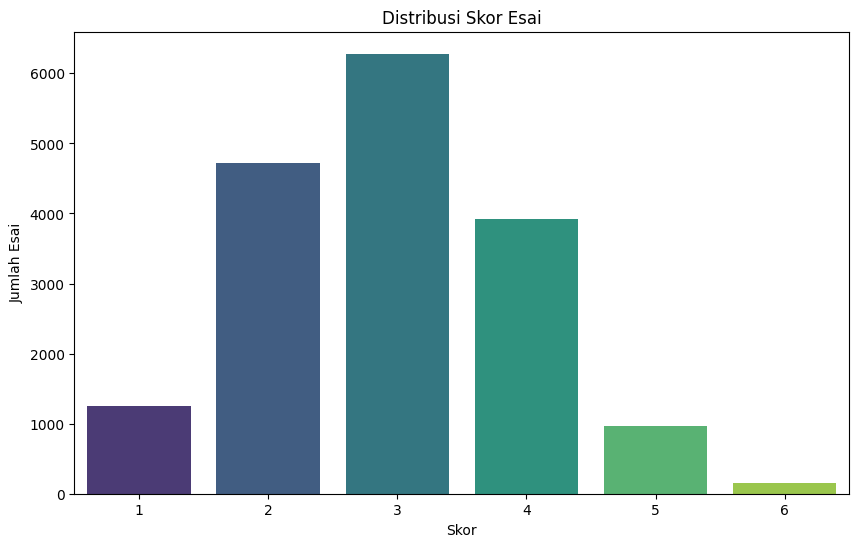

In [ ]:
# Distribusi skor esai
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=train, palette='viridis')
plt.title('Distribusi Skor Esai')
plt.xlabel('Skor')
plt.ylabel('Jumlah Esai')
plt.show()

In [ ]:
train['score'].value_counts()

,count
score,
3,6280
2,4723
4,3926
1,1252
5,970
6,156


In [ ]:
train['full_text'].head()

,full_text
0,Many people have car where they live. The thin...
1,I am a scientist at NASA that is discussing th...
2,People always wish they had the same technolog...
3,"We all heard about Venus, the planet without a..."
4,"Dear, State Senator\n\nThis is a letter to arg..."


# **Preprocessing Data**

In [ ]:
# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
# Implementasi pembersihan teks
train['clean_text'] = train['full_text'].apply(clean_text)
test['clean_text'] = test['full_text'].apply(clean_text)

In [ ]:
train['clean_text'].value_counts()

,count
clean_text,
many people have car where they live the thing they dont know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vaubangermany they dont have that proble because 70 percent of vaubans families do not own carsand 57 percent sold a car to move there street parkig driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders you probaly wont see a car in vaubans streets because they are completely car free but if some that lives in vauban that owns a car ownership is allowedbut there are only two places that you can park a large garages at the edge of the developmentwhere a car owner buys a space but it not cheap to buy one they sell the space for you car for 40000 along with a home the vauban people completed this in 2006 they said that this an example of a growing trend in europethe untile states and some where else are suburban life from auto use this is called smart planning the current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in europe and up to 50 percent in some car intensive in the united states i honeslty think that good idea that they did that is vaudan because that makes cities denser and better for walking and in vauban there are 5500 residents within a rectangular square mile in the artical david gold berg said that all of our development since world war 2 has been centered on the carsand that will have to change and i think that was very true what david gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in vauban so people can see how we really dont need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car it good that they are doing that if you thik about your help the earth in way and thats a very good thing to in the united states the environmental protection agency is promoting what is called car reducedcommuntuntiesand the legislators are starting to actif cautiously maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year in previous bill80 percent of appropriations have by law gone to highways and only 20 percent to other transports there many good reason why they should do this,1
seagoing cowboys program in this essay im going to give you details of why you should sign up to become apart of the seagoing cowboys program the first reason is you will go on many adventures and trips reason two is you get to take care of animals like horses young cows and mules reason three is that youll become an seagoing cowboy you get to help countries and animals to help these countries recover their food supplies animals and more 44 nations will join together to form unrra the united nations relief and rehabliltation adminstration seagoing cowboys will take care of the horses young cows and mules that were shipped oversea it will make you more aware of people of the countries and their needs and that awareness will stay with you it will much of an adventure to you youll have fun on board especially on return trips after the animals had been unloaded youll get to play many games like baseball volleyball games in the empty holds where the animals had been housed tabletennis tournaments fencing boxing whittling and games also helped pass the time sometimes you will be served as night watchman that job means to check on the nails every hour i hope this essay really expired you in excellent many ways to be contined,1
the challenge of exploring venus says much about the challenge and how we might be able to study venus but

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Tokenisasi teks menjadi kata-kata
train_tokens = [word_tokenize(text) for text in train['clean_text']]
test_tokens = [word_tokenize(text) for text in test['clean_text']]

In [ ]:
# Melatih model Word2Vec
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Menyimpan model untuk penggunaan di masa mendatang
model_w2v.save("word2vec_model")

In [ ]:
# Fungsi untuk mendapatkan vektor rata-rata kata
def get_average_word2vec(tokens_list, model, vector_size):
    vec = np.zeros(vector_size)
    valid_words = 0
    for word in tokens_list:
        if word in model.wv:
            vec += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        vec /= valid_words
    return vec

In [ ]:
# Menyusun fitur teks dengan vektor rata-rata Word2Vec
X_train_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in train_tokens])
X_test_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

In [ ]:
import re
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Implementasi pembersihan teks
train['clean_text'] = train['full_text'].apply(clean_text)
test['clean_text'] = test['full_text'].apply(clean_text)

# Tokenisasi teks menjadi kata-kata
train_tokens = [word_tokenize(text) for text in train['clean_text']]
test_tokens = [word_tokenize(text) for text in test['clean_text']]

# Melatih model Word2Vec
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Menyimpan model untuk penggunaan di masa mendatang
model_w2v.save("word2vec_model")

# Fungsi untuk mendapatkan vektor rata-rata kata
def get_average_word2vec(tokens_list, model, vector_size):
    vec = np.zeros(vector_size)
    valid_words = 0
    for word in tokens_list:
        if word in model.wv:
            vec += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        vec /= valid_words
    return vec

# Menyusun fitur teks dengan vektor rata-rata Word2Vec
X_train_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in train_tokens])
X_test_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

# Sekarang, Anda bisa melanjutkan untuk membangun model LSTM atau model lain sesuai kebutuhan Anda.


In [ ]:
# Target variable: the score (1-6)
y_train = train['score'].values



# **Modelling Data**

In [ ]:
# Membagi data X_train_w2v dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_w2v, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
# Mengubah input menjadi 3D untuk LSTM: (batch_size, 1, features)
X_train_final_lstm = np.expand_dims(X_train_final, axis=1)  # Menambahkan dimensi waktu (timesteps)
X_val_lstm = np.expand_dims(X_val, axis=1)

# Membangun model LSTM
model_lstm = Sequential([
    LSTM(128, input_shape=(1, X_train_final.shape[1]), return_sequences=True, kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),  # Aktivasi sigmoid untuk output [0, 1]
    Lambda(lambda x: x * 5 + 1)  # Skala output ke rentang [1, 6]
])

# Kompilasi model
optimizer = Adam(learning_rate=0.0005)
model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Callback untuk early stopping dan pengurangan learning rate
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

# Melatih model
history_lstm = model_lstm.fit(
    X_train_final_lstm, y_train_final,
    epochs=100,  # Tambahkan epoch untuk generalisasi lebih baik
    batch_size=64,  # Eksperimen ukuran batch
    validation_data=(X_val_lstm, y_val),
    callbacks=callbacks,
    verbose=1
)

# Evaluasi model pada data validasi
y_val_pred = model_lstm.predict(X_val_lstm)
y_val_pred = y_val_pred.round().astype(int)  # Pembulatan hasil prediksi

# Cohen's Kappa untuk evaluasi
kappa_score = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print("Cohen's Kappa Score (Validation):", kappa_score)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.8450 - mae: 1.1512 - val_loss: 2.3934 - val_mae: 0.9063 - learning_rate: 5.0000e-04
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.2291 - mae: 0.9143 - val_loss: 1.7293 - val_mae: 0.8046 - learning_rate: 5.0000e-04
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6664 - mae: 0.8260 - val_loss: 1.3799 - val_mae: 0.7496 - learning_rate: 5.0000e-04
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3657 - mae: 0.7869 - val_loss: 1.1653 - val_mae: 0.7192 - learning_rate: 5.0000e-04
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.1792 - mae: 0.7670 - val_loss: 1.0343 - val_mae: 0.7101 - learning_rate: 5.0000e-04
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.0493 - mae: 0.7485 - val_loss: 0.9390 - val_mae: 0.6989 - learning_rate: 5.0000e-04
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9640 - mae: 0.7399 - val_loss: 0.8870 - val_mae: 0.

In [ ]:
# Reshape X_test_w2v to have 3 dimensions: (batch_size, timesteps, features)
X_test_w2v_reshaped = X_test_w2v.reshape(X_test_w2v.shape[0], 1, X_test_w2v.shape[1])

# Prediksi pada data uji
y_pred = model_lstm.predict(X_test_w2v_reshaped)

# Membulatkan hasil prediksi ke integer terdekat dan memastikan rentang [1, 6]
y_pred_rounded = np.rint(y_pred).astype(int)
y_pred_rounded = np.clip(y_pred_rounded, 1, 6)

# Mengisi kolom score di sample_submission
sample_submission['score'] = y_pred_rounded

# Menampilkan beberapa baris hasil prediksi
print(sample_submission[['essay_id', 'score']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  essay_id  score
0  000d118      2
1  000fe60      3
2  001ab80      4


In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

# Membagi data X_train_seq dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Membangun model LSTM dengan perbaikan arsitektur
model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),  # Aktivasi sigmoid untuk rentang [0, 1]
    Lambda(lambda x: x * 5 + 1)  # Mengonversi rentang [0, 1] menjadi [1, 6]
])

# Menggunakan optimizer dengan learning rate lebih rendah
optimizer = Adam(learning_rate=0.0001)

# Kompilasi model dengan menggunakan MAE sebagai loss
model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Melatih model
history_lstm = model_lstm.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

# Prediksi pada data validation dan hitung Cohen's Kappa
y_val_pred = model_lstm.predict(X_val)
y_val_pred = y_val_pred.round().astype(int)  # Pembulatan prediksi ke nilai integer untuk skor

# Menghitung Cohen's Kappa
kappa_score = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print("Cohen's Kappa Score (Validation):", kappa_score)


Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - loss: 1.0039 - mae: 1.0039 - val_loss: 0.8429 - val_mae: 0.8429
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - loss: 0.8634 - mae: 0.8634 - val_loss: 0.7988 - val_mae: 0.7988
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.8374 - mae: 0.8374 - val_loss: 1.0176 - val_mae: 1.0176
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - loss: 0.8190 - mae: 0.8190 - val_loss: 0.8523 - val_mae: 0.8523
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - loss: 0.8083 - mae: 0.8083 - val_loss: 0.9327 - val_mae: 0.9327
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - loss: 0.8085 - mae: 0.8085 - val_loss: 0.8839 - val_mae: 0.8839
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.7999 - mae: 0.7999 - val_loss: 0.9364 - val_mae: 0.9364
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - loss: 0.8065 - mae: 0.8065 - val_loss: 0.8731 - val_mae: 0.8731
Epoch 9/50
217/217 ━━━━━━━━━━━━━

In [ ]:
# Membagi data X_train_w2v dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_w2v, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
# Membuat indeks untuk setiap kata dalam dataset
word_index = {word: idx + 1 for idx, word in enumerate(model_w2v.wv.index_to_key)}

# Mengubah kalimat menjadi indeks kata untuk input LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text_to_sequences(tokens_list, word_index, max_length=1024):
    sequences = []
    for tokens in tokens_list:
        sequence = [word_index.get(word, 0) for word in tokens]
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Menyiapkan data input untuk LSTM
X_train_seq = text_to_sequences(train_tokens, word_index)
X_test_seq = text_to_sequences(test_tokens, word_index)

# Membagi data X_train_seq dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
y_train = train['score'].values
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Membangun model LSTM
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

model_lstm = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),  # Aktivasi sigmoid untuk rentang [0, 1]
    Lambda(lambda x: x * 5 + 1)  # Mengonversi rentang [0, 1] menjadi [1, 6]
])


In [ ]:
# Kompilasi model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
# Melatih model
history_lstm = model_lstm.fit(
    X_train_final, y_train_final,
    epochs=150,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 1.1269 - mae: 0.8320 - val_loss: 1.0887 - val_mae: 0.8018
Epoch 2/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 1.1198 - mae: 0.8231 - val_loss: 1.0932 - val_mae: 0.8204
Epoch 3/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 1.1044 - mae: 0.8174 - val_loss: 1.0891 - val_mae: 0.7847
Epoch 4/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 1.1265 - mae: 0.8182 - val_loss: 1.0885 - val_mae: 0.7862
Epoch 5/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 1.0805 - mae: 0.7999 - val_loss: 1.0921 - val_mae: 0.7929
Epoch 6/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 1.1079 - mae: 0.8112 - val_loss: 1.0881 - val_mae: 0.7919
Epoch 7/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 1.1028 - mae: 0.8086 - val_loss: 1.0859 - val_mae: 0.7995
Epoch 8/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 1.0887 - mae: 0.8045 - val_loss: 1.0911 - val_mae: 0.7854
Epoch 9/150
217/217 ━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Membangun model regresi dengan output 1-6
model = Sequential([
    Input(shape=(X_train_final.shape[1],)),  # Menggunakan Input layer untuk mendefinisikan dimensi input
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),  # Aktivasi sigmoid untuk memastikan output dalam rentang [0,1]
    Lambda(lambda x: x * 5 + 1)  # Mengonversi rentang [0,1] menjadi [1,6]
])


In [ ]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
# Melatih model
history = model.fit(
    X_train_final, y_train_final,
    epochs=150,  # Sesuaikan sesuai kebutuhan
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0500 - mae: 0.8247 - val_loss: 0.7865 - val_mae: 0.7205
Epoch 2/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8280 - mae: 0.7316 - val_loss: 0.7290 - val_mae: 0.6896
Epoch 3/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7515 - mae: 0.6968 - val_loss: 0.7100 - val_mae: 0.6753
Epoch 4/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7471 - mae: 0.6930 - val_loss: 0.7003 - val_mae: 0.6711
Epoch 5/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7061 - mae: 0.6705 - val_loss: 0.6739 - val_mae: 0.6610
Epoch 6/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6884 - mae: 0.6685 - val_loss: 0.6770 - val_mae: 0.6575
Epoch 7/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6721 - mae: 0.6575 - val_loss: 0.6654 - val_mae: 0.6556
Epoch 8/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6853 - mae: 0.6609 - val_loss: 0.6450 - val_mae: 0.6422
Epoch 9/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [ ]:
# Evaluasi model pada data validasi
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation MAE: {val_mae:.4f}')

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluasi model pada data validasi
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation MAE: {val_mae:.4f}')

# Prediksi pada data validasi
y_val_pred = model.predict(X_val)

# Membulatkan prediksi ke integer terdekat
y_val_pred_rounded = np.rint(y_val_pred).astype(int)

# Hitung akurasi
accuracy = accuracy_score(y_val, y_val_pred_rounded)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 100, but received input with shape (None, 1024)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1024), dtype=int32)
  • training=False
  • mask=None

In [ ]:
# Prediksi pada data uji
y_pred = model.predict(X_test_w2v)

# Membulatkan hasil prediksi ke integer terdekat
y_pred_rounded = np.rint(y_pred).astype(int)  # Pastikan skor tetap dalam rentang 1-6
y_pred_rounded = np.clip(y_pred_rounded, 1, 6)  # Kliping agar nilai tetap dalam rentang 1-6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
# Memastikan kolom yang ada dalam sample_submission
sample_submission['score'] = y_pred_rounded

# Menampilkan prediksi
print(sample_submission.head())  # Menampilkan beberapa baris pertama hasil prediksi

  essay_id  score
0  000d118      2
1  000fe60      3
2  001ab80      4
